In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score



# Load data

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
type(mnist)

In [ ]:
# function to sort data 
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [ ]:
mnist["data"], mnist["target"]

In [ ]:
mnist.data.shape

## Assign data 

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

In [ ]:
y.shape

## Peak into a row of data

In [2]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
some_digit = X[36000]

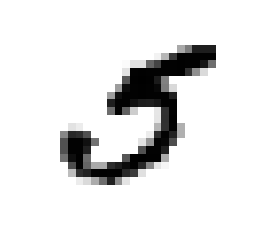

In [12]:
plot_digit(some_digit)

## Visualize data 

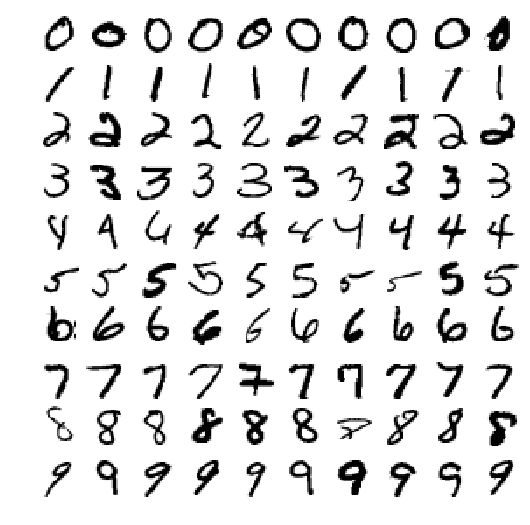

In [3]:
# EXTRA, combine into single array. Another option would be to facet plot 
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

## Save data 

In [ ]:
joblib.dump(mnist, 'data/raw/'+'mnist'+'.pkl')

## Load saved data

In [2]:
mnist = joblib.load('data/raw/'+'mnist'+'.pkl')
X, y = mnist["data"], mnist["target"]

# Split data into training sets 

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Shuffle data
This helps to properly train the model so that it doesn't see the same data in a row 

In [5]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Train a Binary Classiffier 

In [6]:
# selects all labels equal to 5 to True, otherwise False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
y_test_5

array([False, False, False, ..., False, False, False])

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

## Make prediction 

In [10]:
# test on previous sample 
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([ True])

# Measure Binary Classifier Performance 
Using accuracy doesn't work for a classifier, because even a dummy classifier could guess correctly 90% of the time

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

## Confusion Matrix 
much better for judging classifier 

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [14]:
# a perfect matrix would have all zeros along the diagonal
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision, accuracy of positive predictions 
precision = $\frac{TP}{TP+FP}$

In [15]:
precision_score(y_train_5, y_train_pred)

0.7687135020350381

## Recall (sensitivity or true positive rate) ratio of positive instances correctly detected by classifier  
recall = $\frac{TP}{TP+FN}$

In [16]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

## $F_1$ score, the harmonic mean of precision and recall 

In [18]:
f1_score(y_train_5, y_train_pred)

0.7846820809248555